In [61]:
import glob
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML

images = glob.glob('camera_cal/calibration*.jpg')
objpoints = []
imgpoints = []

objp = np.zeros((6*9,3), np.float32)
#print (objp)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

for fname in images:
    #print (fname)
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)


In [62]:
# Output calibration results
out_path = "camera_cal_outputs/"
for fname in images:
    original = mpimg.imread(fname)
    result = undistort_image(original, mtx, dist)
    #print (fname)
    img_name = fname.split('/')[1]
    file_name, file_ext = img_name.split('.')
    out_file_name = file_name + '_out.' + file_ext
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    save_path = os.path.join(out_path, out_file_name)
    plt.imsave(save_path, result)

In [72]:
# Finding lane lines
def find_lane_pixels(binary_warped):
    #binary_warped = binary_warped[:,:,0]
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis = 0)
    
    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    midpoint = np.int(histogram.shape[0]//2)
    
    quarter_point = np.int(midpoint//2)
    #histogram[midpoint+quarter_point:] = 0
    #plt.plot(histogram)
    leftx_base = np.argmax(histogram[quarter_point:midpoint]) + quarter_point
    rightx_base = np.argmax(histogram[midpoint:midpoint+quarter_point]) + midpoint
    nwindows = 9
    margin = 100
    minpix = 50
    
    window_height = np.int(binary_warped.shape[0]//nwindows)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base
    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low), (win_xleft_high,win_y_high),(0,255,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low), (win_xright_high,win_y_high),(0,255,0), 3)
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high)
                         & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high)
                          & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = int(np.mean(nonzerox[good_right_inds]))
            
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(binary_warped):
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    #plt.imshow(out_img)

    return out_img, left_fit, right_fit, ploty, leftx, rightx, lefty, righty

In [76]:
# Fit polynomial from previous frame
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    # left_fit: coefficients of left lane
    # right_fit: coefficients of right lane
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, img_shape[0] - 1, img_shape[0])
    left_fitx = np.polyval(left_fit, ploty)
    right_fitx = np.polyval(right_fit, ploty)
    
    return left_fitx, right_fitx, ploty, left_fit, right_fit

def search_around_poly(binary_warped, left_fit, right_fit):
    # left_fit: coefficients of left lane
    # right_fit: coefficients of right lane
    margin = 100
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    leftfit_x = np.polyval(left_fit, nonzeroy)
    rightfit_x = np.polyval(right_fit, nonzeroy)
    left_lane_inds = ((nonzerox > (leftfit_x - margin)) & (nonzerox < (leftfit_x + margin)))
    right_lane_inds = ((nonzerox > (rightfit_x - margin)) & (nonzerox < (rightfit_x + margin)))
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fitx, right_fitx, ploty, left_fit, right_fit = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    # Visualization
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255,0,0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0,0,255]
    
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))    
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.imshow(result)
    ## End visualization steps ##
    
    return result, left_fit, right_fit, ploty

In [4]:
# Calculate Curvature
def measure_carvature_pixels():
    y_eval = np.max(ploty)
    
    left_curverad = np.sqrt(((2*left_fit[0]*y_eval + left_fit[1])**2 + 1)**3) / np.abs(2*left_fit[0])
    right_curverad = np.sqrt(((2*right_fit[0]*y_eval + right_fit[1])**2 + 1)**3) / np.abs(2*right_fit[0])
    
    return left_curverad, right_curverad

In [46]:
#def measure_carvature_real(binary_warped, leftx, lefty, rightx, righty, left_fit, right_fit):
def measure_carvature_real(binary_warped, left_fit, right_fit):
    ym_per_pix = 30/720
    xm_per_pix = 3.7/700
    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    y_eval = np.max(ploty)
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    #left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    #right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    car_center = binary_warped.shape[0] / 2
    lane_center = ((left_fit[0]*binary_warped.shape[0]**2 + left_fit[1]*binary_warped.shape[0] + left_fit[2])
                  + (right_fit[0]*binary_warped.shape[0]**2 + right_fit[1]*binary_warped.shape[0] + right_fit[2])) / 2
    
    offset = (car_center - lane_center) * xm_per_pix
    return left_curverad, right_curverad, offset


In [6]:
# Draw the detected boundaries back to the original image
def draw_detected_area(original, binary_warped, left_fit, right_fit, Minv):
    warp_zeros = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zeros, warp_zeros, warp_zeros))

    # Recast the x and y points into usable format for cv2.fillPoly()
    #left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    cv2.fillPoly(color_warp, np.int_([pts]), (0,255,0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (binary_warped.shape[1], binary_warped.shape[0]))
    result = cv2.addWeighted(original, 1, newwarp, 0.3, 0)
    
    return result

In [7]:
# Output carvature and car offset
def print_carvatureAndOffset(img, left_carvature, right_carvature, offset):
    radius = (left_carvature + right_carvature) / 2
    # negative offset, to the left
    direction = 'right'
    if offset < 0:
        direction = 'left'
    offset = np.absolute(offset)
    cv2.putText(img,'Radius:{:04.2f}m.'.format(radius), (100,100), cv2.FONT_HERSHEY_SIMPLEX, 1.8, (0,255,0),3, cv2.LINE_AA)
    cv2.putText(img,'Offset:{:04.2f}m to the {} of the center.'.format(offset, direction), (100,200), cv2.FONT_HERSHEY_SIMPLEX, 1.8, (0,255,0),3,cv2.LINE_AA)


In [8]:
# Put everything together to get a pipeline
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def undistort_image(img, mtx, dist):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

def threshold_bin_image(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary

def perspective_transform_image(img):
    img_size = img.shape[1], img.shape[0]

    src = np.float32([(570,460),
                      (700,460), 
                      (260,680), 
                      (1050,680)])
    dst = np.float32([(450,0),
                      (830,0),
                      (450,img.shape[0]),
                      (830,img.shape[0])])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, M, Minv


In [59]:
# Line class for video processing
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        # last n coefficients
        self.recent_fits = []
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
    
    def update(self, line_fit, is_valid, ploty):
        if is_valid == True:
            self.detected = True
            self.recent_xfitted.append(line_fit[0]*ploty**2 + line_fit[1]*ploty + line_fit[2])
            self.recent_fits.append(line_fit)
            if len(self.recent_xfitted) > 5:
                self.recent_xfitted.pop(0)
            if len(self.recent_fits) > 5:
                self.recent_fits.pop(0)
            self.bestx = np.mean(self.recent_xfitted, axis = 0)
            self.current_fit = line_fit
            self.best_fit = np.mean(self.recent_fits, axis = 0) 
        else:
            self.detected = False
            if len(self.recent_xfitted) > 0:
                self.recent_xfitted.pop(0)
            if len(self.recent_fits) > 0:
                self.recent_fits.pop(0)
            if len(self.recent_xfitted) > 0:
                self.bestx = np.mean(self.recent_xfitted, axis = 0)
                self.best_fit = np.mean(self.recent_fits, axis = 0)
                
    def update_curvature(self, curverad, offset):
        curvature_error = 500
        if self.radius_of_curvature is None:
            self.radius_of_curvature = curverad
            return
        else:
            if np.absolute(self.radius_of_curvature - curverad) > curvature_error:
                self.detected = False
            else:
                self.radius_of_curvature = curverad

In [60]:
# Check if two lanes are parallel
def is_parallel(left_fit, right_fit, ploty):
    if (left_fit is None) or (right_fit is None):
        return False
    
    parallel_error = 400 # pixels
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    #print ('parallel error:{}'.format(np.absolute(np.mean(left_fitx - right_fitx))))
    if np.absolute(np.mean(left_fitx - right_fitx)) > parallel_error:
        return False
    
    return True

'\nimages = glob.glob(\'test_images/straight_lines*.jpg\')\nout_path = "output_images/"\n\nfor fname in images:\n    original = mpimg.imread(fname)\n    result = pipeline(original)\n    #print (fname)\n    img_name = fname.split(\'/\')[1]\n    file_name, file_ext = img_name.split(\'.\')\n    out_file_name = file_name + \'_polyfit.\' + file_ext\n    if not os.path.exists(out_path):\n        os.makedirs(out_path)\n    save_path = os.path.join(out_path, out_file_name)\n    plt.imsave(save_path, result)\n'

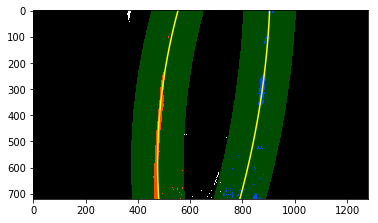

In [79]:
left_line = Line()
right_line = Line()

def pipeline(img):
    vertices = np.array([[(570,440),(150, img.shape[0]), (1200,img.shape[0]), (750, 450)]], dtype=np.int32)
    undist = undistort_image(img, mtx, dist)
    binary_img = threshold_bin_image(undist)
    #plt.imshow(binary_img)
    binary_img = region_of_interest(binary_img, vertices)
    #plt.imshow(binary_img)
    binary_warped, M, Minv = perspective_transform_image(binary_img)
    '''
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(binary_img, cmap = 'gray')
    ax2.imshow(undist, cmap = 'gray')
    '''
    # Line processing for video input
    if left_line.detected and right_line.detected:
        result, left_fit, right_fit, ploty = search_around_poly(binary_warped, left_line.best_fit, right_line.best_fit)
    else:
        result, left_fit, right_fit, ploty, leftx, rightx, lefty, righty = fit_polynomial(binary_warped)
        
    is_valid_lanes = True
    if is_parallel(left_fit, right_fit, ploty) == False:
        #print ('not parallel')
        is_valid_lanes = False
        
    #print (type(is_valid_lanes))
    left_line.update(left_fit, is_valid_lanes, ploty)
    right_line.update(right_fit, is_valid_lanes, ploty)
    
    
    #out_img, left_fit, right_fit, ploty, leftx, rightx, lefty, righty = fit_polynomial(binary_warped)
    #result, left_fit, right_fit = search_around_poly(binary_warped, left_fit, right_fit)
    #ax3.imshow(out_img)
    #f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
    #f.tight_layout()
    #ax1.imshow(binary_img, cmap = 'gray')
    #ax2.imshow(binary_warped, cmap = 'gray')
    #ax3.imshow(result)
    if (left_line.best_fit is not None) and (right_line.best_fit is not None):
        left_curverad, right_curverad, offset = measure_carvature_real(binary_warped, left_line.best_fit, right_line.best_fit)
        left_line.update_curvature(left_curverad, offset)
        right_line.update_curvature(right_curverad, offset)
        img_with_detected_area = draw_detected_area(img, binary_warped, left_line.best_fit, right_line.best_fit, Minv)
        print_carvatureAndOffset(img_with_detected_area, left_curverad, right_curverad, offset)
    else:
        img_with_detected_area = np.copy(img)
        
    return img_with_detected_area

fname = 'test_images/test1.jpg'
img = mpimg.imread(fname)
result = pipeline(img)
#plt.imshow(result)
fname = 'test_images/test1.jpg'
img = mpimg.imread(fname)
result = pipeline(img)
'''
images = glob.glob('test_images/straight_lines*.jpg')
out_path = "output_images/"

for fname in images:
    original = mpimg.imread(fname)
    result = pipeline(original)
    #print (fname)
    img_name = fname.split('/')[1]
    file_name, file_ext = img_name.split('.')
    out_file_name = file_name + '_polyfit.' + file_ext
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    save_path = os.path.join(out_path, out_file_name)
    plt.imsave(save_path, result)
'''

In [58]:
# Process video inputs
left_line = Line()
right_line = Line()
video_output = 'project_video_output.mp4'
video_input = VideoFileClip('project_video.mp4')
processed_video = video_input.fl_image(pipeline)
%time processed_video.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4






  0%|          | 0/1261 [00:00<?, ?it/s]



  0%|          | 1/1261 [00:00<02:32,  8.27it/s]



  0%|          | 2/1261 [00:00<02:34,  8.14it/s]



  0%|          | 3/1261 [00:00<02:33,  8.18it/s]



  0%|          | 4/1261 [00:00<02:30,  8.34it/s]



  0%|          | 5/1261 [00:00<02:32,  8.24it/s]



  0%|          | 6/1261 [00:00<02:43,  7.69it/s]



  1%|          | 7/1261 [00:00<02:41,  7.76it/s]



  1%|          | 8/1261 [00:01<02:50,  7.33it/s]



  1%|          | 9/1261 [00:01<02:40,  7.79it/s]



  1%|          | 10/1261 [00:01<02:45,  7.55it/s]



  1%|          | 11/1261 [00:01<02:51,  7.30it/s]



  1%|          | 12/1261 [00:01<02:44,  7.61it/s]



  1%|          | 13/1261 [00:01<02:43,  7.64it/s]



  1%|          | 14/1261 [00:01<03:19,  6.24it/s]



  1%|          | 15/1261 [00:02<03:09,  6.56it/s]



  1%|▏         | 16/1261 [00:02<02:52,  7.24it/s]



  1%|▏         | 17/1261 [00:02<02:39,  7.80it/s]



  1%|▏         | 18/1261 [00:02<02:32,  8.15it/s]



  2%|▏ 

 10%|▉         | 125/1261 [00:18<02:35,  7.29it/s]



 10%|▉         | 126/1261 [00:18<02:46,  6.83it/s]



 10%|█         | 127/1261 [00:18<02:44,  6.88it/s]



 10%|█         | 128/1261 [00:18<02:53,  6.53it/s]



 10%|█         | 129/1261 [00:19<02:51,  6.60it/s]



 10%|█         | 130/1261 [00:19<02:42,  6.97it/s]



 10%|█         | 131/1261 [00:19<02:42,  6.93it/s]



 10%|█         | 132/1261 [00:19<02:47,  6.76it/s]



 11%|█         | 133/1261 [00:19<02:45,  6.81it/s]



 11%|█         | 134/1261 [00:19<02:44,  6.86it/s]



 11%|█         | 135/1261 [00:19<02:49,  6.63it/s]



 11%|█         | 136/1261 [00:20<02:43,  6.86it/s]



 11%|█         | 137/1261 [00:20<03:07,  6.01it/s]



 11%|█         | 138/1261 [00:20<03:13,  5.80it/s]



 11%|█         | 139/1261 [00:20<03:03,  6.12it/s]



 11%|█         | 140/1261 [00:20<03:01,  6.19it/s]



 11%|█         | 141/1261 [00:20<02:52,  6.48it/s]



 11%|█▏        | 142/1261 [00:21<02:55,  6.36it/s]



 11%|█▏        | 143/1261 [0

 21%|██        | 266/1261 [00:35<01:37, 10.16it/s]



 21%|██▏       | 268/1261 [00:35<01:40,  9.91it/s]



 21%|██▏       | 269/1261 [00:35<01:50,  9.02it/s]



 21%|██▏       | 270/1261 [00:35<01:49,  9.08it/s]



 21%|██▏       | 271/1261 [00:35<01:49,  9.02it/s]



 22%|██▏       | 272/1261 [00:35<01:50,  8.99it/s]



 22%|██▏       | 273/1261 [00:35<01:46,  9.24it/s]



 22%|██▏       | 274/1261 [00:36<01:48,  9.06it/s]



 22%|██▏       | 275/1261 [00:36<01:46,  9.25it/s]



 22%|██▏       | 276/1261 [00:36<01:45,  9.33it/s]



 22%|██▏       | 277/1261 [00:36<01:47,  9.13it/s]



 22%|██▏       | 278/1261 [00:36<01:48,  9.07it/s]



 22%|██▏       | 279/1261 [00:36<01:47,  9.13it/s]



 22%|██▏       | 281/1261 [00:36<01:41,  9.68it/s]



 22%|██▏       | 282/1261 [00:36<01:40,  9.73it/s]



 22%|██▏       | 283/1261 [00:36<01:39,  9.79it/s]



 23%|██▎       | 284/1261 [00:37<01:40,  9.70it/s]



 23%|██▎       | 285/1261 [00:37<01:41,  9.65it/s]



 23%|██▎       | 286/1261 [0

 32%|███▏      | 402/1261 [00:51<02:20,  6.13it/s]



 32%|███▏      | 403/1261 [00:51<02:04,  6.91it/s]



 32%|███▏      | 404/1261 [00:51<01:53,  7.53it/s]



 32%|███▏      | 405/1261 [00:51<02:06,  6.74it/s]



 32%|███▏      | 406/1261 [00:51<02:20,  6.10it/s]



 32%|███▏      | 407/1261 [00:52<02:24,  5.89it/s]



 32%|███▏      | 408/1261 [00:52<02:21,  6.04it/s]



 32%|███▏      | 409/1261 [00:52<02:21,  6.04it/s]



 33%|███▎      | 410/1261 [00:52<02:32,  5.60it/s]



 33%|███▎      | 411/1261 [00:52<02:28,  5.72it/s]



 33%|███▎      | 412/1261 [00:52<02:12,  6.39it/s]



 33%|███▎      | 413/1261 [00:53<02:08,  6.62it/s]



 33%|███▎      | 414/1261 [00:53<02:21,  6.00it/s]



 33%|███▎      | 415/1261 [00:53<02:13,  6.36it/s]



 33%|███▎      | 416/1261 [00:53<02:02,  6.91it/s]



 33%|███▎      | 417/1261 [00:53<01:52,  7.50it/s]



 33%|███▎      | 418/1261 [00:53<01:48,  7.74it/s]



 33%|███▎      | 419/1261 [00:53<01:43,  8.13it/s]



 33%|███▎      | 420/1261 [0

 42%|████▏     | 526/1261 [01:11<01:31,  7.99it/s]



 42%|████▏     | 527/1261 [01:11<01:31,  8.00it/s]



 42%|████▏     | 528/1261 [01:11<01:29,  8.21it/s]



 42%|████▏     | 529/1261 [01:12<01:29,  8.22it/s]



 42%|████▏     | 530/1261 [01:12<01:26,  8.40it/s]



 42%|████▏     | 531/1261 [01:12<01:25,  8.51it/s]



 42%|████▏     | 532/1261 [01:12<01:29,  8.14it/s]



 42%|████▏     | 533/1261 [01:12<01:31,  7.99it/s]



 42%|████▏     | 534/1261 [01:12<01:32,  7.90it/s]



 43%|████▎     | 536/1261 [01:12<01:24,  8.59it/s]



 43%|████▎     | 537/1261 [01:12<01:21,  8.89it/s]



 43%|████▎     | 538/1261 [01:13<01:26,  8.34it/s]



 43%|████▎     | 539/1261 [01:13<01:30,  8.00it/s]



 43%|████▎     | 540/1261 [01:13<01:42,  7.03it/s]



 43%|████▎     | 541/1261 [01:13<01:46,  6.75it/s]



 43%|████▎     | 542/1261 [01:13<01:49,  6.54it/s]



 43%|████▎     | 543/1261 [01:13<01:54,  6.28it/s]



 43%|████▎     | 544/1261 [01:14<01:58,  6.06it/s]



 43%|████▎     | 545/1261 [0

 53%|█████▎    | 666/1261 [01:28<01:15,  7.87it/s]



 53%|█████▎    | 667/1261 [01:29<01:12,  8.16it/s]



 53%|█████▎    | 668/1261 [01:29<01:13,  8.02it/s]



 53%|█████▎    | 669/1261 [01:29<01:15,  7.87it/s]



 53%|█████▎    | 670/1261 [01:29<01:15,  7.86it/s]



 53%|█████▎    | 671/1261 [01:29<01:12,  8.12it/s]



 53%|█████▎    | 672/1261 [01:29<01:13,  8.06it/s]



 53%|█████▎    | 673/1261 [01:29<01:12,  8.09it/s]



 53%|█████▎    | 674/1261 [01:29<01:12,  8.14it/s]



 54%|█████▎    | 675/1261 [01:30<01:11,  8.17it/s]



 54%|█████▎    | 676/1261 [01:30<01:13,  7.95it/s]



 54%|█████▎    | 677/1261 [01:30<01:12,  8.01it/s]



 54%|█████▍    | 678/1261 [01:30<01:11,  8.11it/s]



 54%|█████▍    | 679/1261 [01:30<01:10,  8.31it/s]



 54%|█████▍    | 680/1261 [01:30<01:09,  8.33it/s]



 54%|█████▍    | 681/1261 [01:30<01:10,  8.28it/s]



 54%|█████▍    | 682/1261 [01:30<01:11,  8.11it/s]



 54%|█████▍    | 683/1261 [01:31<01:10,  8.16it/s]



 54%|█████▍    | 684/1261 [0

 63%|██████▎   | 790/1261 [01:44<01:18,  6.00it/s]



 63%|██████▎   | 791/1261 [01:45<01:13,  6.40it/s]



 63%|██████▎   | 792/1261 [01:45<01:08,  6.89it/s]



 63%|██████▎   | 793/1261 [01:45<01:09,  6.76it/s]



 63%|██████▎   | 794/1261 [01:45<01:07,  6.97it/s]



 63%|██████▎   | 795/1261 [01:45<01:02,  7.50it/s]



 63%|██████▎   | 796/1261 [01:45<01:01,  7.52it/s]



 63%|██████▎   | 797/1261 [01:45<00:58,  7.96it/s]



 63%|██████▎   | 798/1261 [01:46<00:59,  7.82it/s]



 63%|██████▎   | 799/1261 [01:46<00:56,  8.20it/s]



 63%|██████▎   | 800/1261 [01:46<00:56,  8.19it/s]



 64%|██████▎   | 801/1261 [01:46<00:54,  8.49it/s]



 64%|██████▎   | 802/1261 [01:46<00:55,  8.28it/s]



 64%|██████▎   | 803/1261 [01:46<00:53,  8.62it/s]



 64%|██████▍   | 804/1261 [01:46<00:53,  8.53it/s]



 64%|██████▍   | 805/1261 [01:46<00:54,  8.44it/s]



 64%|██████▍   | 806/1261 [01:47<01:06,  6.80it/s]



 64%|██████▍   | 807/1261 [01:47<01:04,  7.03it/s]



 64%|██████▍   | 808/1261 [0

 72%|███████▏  | 914/1261 [02:06<01:08,  5.09it/s]



 73%|███████▎  | 915/1261 [02:06<01:00,  5.74it/s]



 73%|███████▎  | 916/1261 [02:06<01:04,  5.33it/s]



 73%|███████▎  | 917/1261 [02:07<01:05,  5.27it/s]



 73%|███████▎  | 918/1261 [02:07<01:02,  5.50it/s]



 73%|███████▎  | 919/1261 [02:07<00:57,  5.91it/s]



 73%|███████▎  | 920/1261 [02:07<00:52,  6.50it/s]



 73%|███████▎  | 921/1261 [02:07<00:50,  6.78it/s]



 73%|███████▎  | 922/1261 [02:07<00:49,  6.83it/s]



 73%|███████▎  | 923/1261 [02:07<00:46,  7.31it/s]



 73%|███████▎  | 924/1261 [02:08<00:47,  7.16it/s]



 73%|███████▎  | 925/1261 [02:08<00:45,  7.43it/s]



 73%|███████▎  | 926/1261 [02:08<00:45,  7.33it/s]



 74%|███████▎  | 927/1261 [02:08<00:42,  7.79it/s]



 74%|███████▎  | 928/1261 [02:08<00:43,  7.62it/s]



 74%|███████▎  | 929/1261 [02:08<00:41,  7.95it/s]



 74%|███████▍  | 930/1261 [02:08<00:42,  7.74it/s]



 74%|███████▍  | 931/1261 [02:08<00:40,  8.05it/s]



 74%|███████▍  | 932/1261 [0

 82%|████████▏ | 1038/1261 [02:25<00:28,  7.76it/s]



 82%|████████▏ | 1039/1261 [02:25<00:28,  7.70it/s]



 82%|████████▏ | 1040/1261 [02:25<00:28,  7.88it/s]



 83%|████████▎ | 1041/1261 [02:26<00:28,  7.67it/s]



 83%|████████▎ | 1042/1261 [02:26<00:28,  7.73it/s]



 83%|████████▎ | 1043/1261 [02:26<00:28,  7.58it/s]



 83%|████████▎ | 1044/1261 [02:26<00:27,  7.87it/s]



 83%|████████▎ | 1045/1261 [02:26<00:27,  7.78it/s]



 83%|████████▎ | 1046/1261 [02:26<00:28,  7.55it/s]



 83%|████████▎ | 1047/1261 [02:26<00:29,  7.19it/s]



 83%|████████▎ | 1048/1261 [02:27<00:29,  7.23it/s]



 83%|████████▎ | 1049/1261 [02:27<00:30,  7.00it/s]



 83%|████████▎ | 1050/1261 [02:27<00:28,  7.38it/s]



 83%|████████▎ | 1051/1261 [02:27<00:27,  7.62it/s]



 83%|████████▎ | 1052/1261 [02:27<00:26,  7.96it/s]



 84%|████████▎ | 1053/1261 [02:27<00:27,  7.63it/s]



 84%|████████▎ | 1054/1261 [02:27<00:25,  7.96it/s]



 84%|████████▎ | 1055/1261 [02:27<00:29,  7.05it/s]



 84%|█████

 92%|█████████▏| 1160/1261 [02:42<00:13,  7.70it/s]



 92%|█████████▏| 1161/1261 [02:43<00:12,  7.76it/s]



 92%|█████████▏| 1162/1261 [02:43<00:12,  7.78it/s]



 92%|█████████▏| 1163/1261 [02:43<00:12,  7.81it/s]



 92%|█████████▏| 1164/1261 [02:43<00:13,  7.12it/s]



 92%|█████████▏| 1165/1261 [02:43<00:12,  7.66it/s]



 92%|█████████▏| 1166/1261 [02:43<00:12,  7.64it/s]



 93%|█████████▎| 1167/1261 [02:43<00:11,  8.01it/s]



 93%|█████████▎| 1168/1261 [02:43<00:11,  7.90it/s]



 93%|█████████▎| 1169/1261 [02:44<00:11,  8.26it/s]



 93%|█████████▎| 1170/1261 [02:44<00:11,  8.11it/s]



 93%|█████████▎| 1171/1261 [02:44<00:11,  8.11it/s]



 93%|█████████▎| 1172/1261 [02:44<00:11,  8.01it/s]



 93%|█████████▎| 1173/1261 [02:44<00:10,  8.15it/s]



 93%|█████████▎| 1174/1261 [02:44<00:10,  8.07it/s]



 93%|█████████▎| 1175/1261 [02:44<00:10,  8.45it/s]



 93%|█████████▎| 1176/1261 [02:44<00:09,  8.55it/s]



 93%|█████████▎| 1177/1261 [02:44<00:09,  8.67it/s]



 93%|█████

[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 2min 20s, sys: 29 s, total: 2min 49s
Wall time: 2min 57s


In [ ]:
# Challenge video
'''
video_output = 'challenge_video_output.mp4'
video_input = VideoFileClip('challenge_video.mp4').subclip(0,10)
processed_video = video_input.fl_image(pipeline)
%time processed_video.write_videofile(video_output, audio=False)
'''

In [ ]:
# Harder challenge video
'''
video_output = 'harder_challenge_video_output.mp4'
video_input = VideoFileClip('harder_challenge_video.mp4').subclip(0,10)
processed_video = video_input.fl_image(pipeline)
%time processed_video.write_videofile(video_output, audio=False)
'''